In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing,

import matplotlib.pyplot as plt
#from IPython.display import display

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,models
from torchvision.utils import make_grid
import cv2 # cv2.imread

import os # os.path

In [24]:
path='flowers/flowers/'

In [25]:
img_names = []
for folder,subfolders,filenames in os.walk(path):
    for img in filenames:
        img_names.append(folder+'/'+img)
print("images len:",len(img_names))


images len: 4326


In [29]:
img_sizes = []
rejected = []
for item in img_names:
    try:
        img = cv2.imread(item)
        img_sizes.append(img.shape[1::-1]) # img.shape -> (height,width,channel)->(width,height)
    except:
        rejected.append(item)
print(f'images:{len(img_sizes)}')
print(f'rejected:{len(rejected)}')

images:4323
rejected:3


## Data Augmentation

## Calculate Parameter of Normalization

In [31]:
transform = {
    "train": transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
    ]),
    "Test": transforms.Compose({
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.485,0.456,0.406], std = [0.229,0.224,0.225])
    })
}

In [32]:
root='flowers/'

full_dataset = datasets.ImageFolder(os.path.join(root,'flowers'),transform=transform["train"])
print('full dataset:',full_dataset)

full dataset: Dataset ImageFolder
    Number of datapoints: 4323
    Root location: flowers/flowers
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.5, 1.5], contrast=None, saturation=None, hue=None)
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [33]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

print('train size:',train_size)
print('test size:',test_size)
train_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train size: 3458
test size: 865


In [34]:
train_btch_size =20
test_btch_size = 10

train_loader = DataLoader(train_data,batch_size=train_btch_size, shuffle = True,num_workers = 8)
test_loader =  DataLoader(test_data,batch_size =test_btch_size ,shuffle = False,num_workers = 8)

class_names = full_dataset.classes
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [35]:
class ConvolutionalNetworks(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.conv3 = nn.Conv2d(64,128,3,1)
        self.fc1   = nn.Linear(128*26*26,16)
        self.fc2   = nn.Linear(16,8)
        self.fc3   = nn.Linear(8,6)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,128*26*26)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim =1)

In [36]:
# We are going to use pytorch GPU therefore we need to convert datatypes into .cuda() format
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()
use_gpu

False

In [37]:
CNN_model=ConvolutionalNetworks()
if torch.cuda.is_available():
    CNN_model.cuda() 
criterion= nn.CrossEntropyLoss()
if use_gpu:
     criterion = criterion.cuda()
optimizer = torch.optim.Adam(CNN_model.parameters(),lr=0.001)
CNN_model

ConvolutionalNetworks(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=6, bias=True)
)

## Epoch

3+6 epochs.

In [39]:
epochs = 6
train_losses =[]
test_losses = []
train_correct =[]
test_correct=[]
for epoch in range(epochs):
    
    trn_corr =0
    tst_corr =0
    for batch,(X_train,y_train) in enumerate(train_loader):
        batch+=1
        if torch.cuda.is_available():
            X_train = Variable(X_train).cuda()
            y_train = Variable(y_train).cuda()
        
        y_pred = CNN_model(X_train)
        loss   = criterion(y_pred,y_train)
        predicted =torch.max(y_pred.data,1)[1]
        trn_corr+=(predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%100 ==0:
            print(f'epoch:{epoch} batch:{batch} loss:{loss.item()} accuracy:{trn_corr.item()*100/(batch*train_btch_size)}')
            
        
    train_losses.append(loss)
    train_correct.append(trn_corr.item()*100/(batch*train_btch_size))
    
    with torch.no_grad():
        for X_test,y_test in test_loader:
            
            if torch.cuda.is_available():
                X_test = Variable(X_test).cuda()
                y_test = Variable(y_test).cuda()

            y_val= CNN_model(X_test)
            predicted_test = torch.max(y_val.data,1)[1]
            tst_corr +=(predicted_test==y_test).sum()

        loss =criterion(y_val,y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr.item()*100/(batch*test_btch_size))  
    

epoch:0 batch:100 loss:0.7769767045974731 accuracy:60.35
epoch:1 batch:100 loss:0.9560750126838684 accuracy:63.8
epoch:2 batch:100 loss:0.8768895268440247 accuracy:67.4
epoch:3 batch:100 loss:0.9846696853637695 accuracy:70.1
epoch:4 batch:100 loss:0.3255961537361145 accuracy:71.0
epoch:5 batch:100 loss:1.1607993841171265 accuracy:73.75


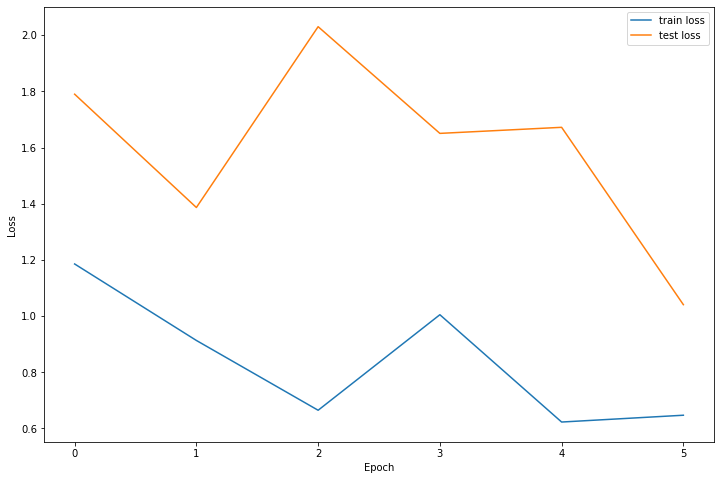

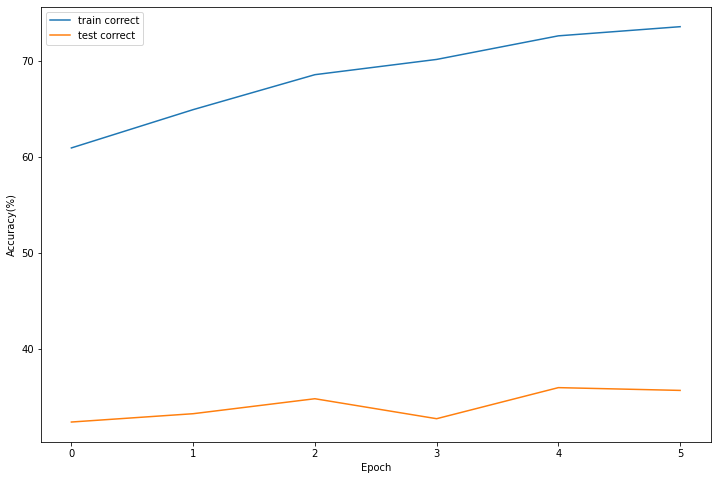

In [41]:
#  Plot train loss and test loss 
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses,label = 'train loss')
plt.plot(test_losses,label  = 'test loss')
plt.legend()

#  Plot train and test accuracy
plt.figure(figsize=(12,8))
plt.xlabel("Epoch")
plt.ylabel("Accuracy(%)")
plt.plot(train_correct,label = 'train correct')
plt.plot(test_correct, label = 'test correct')
plt.legend()